<a href="https://colab.research.google.com/github/ravikarora/E-CRM-using-Machine-Learning/blob/main/rmf_analysis_and_k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation using RMF Analysis and K-means clustering

This is part of my individual project for Data Analyst Program 22 at Hyper Island.

### Topic: How E-commerce companies can utilize customer's behavioral data to improve CRM

#### Focusing on customer segmentation using RMF Analysis and K-means clustering in Python
- Dataset: The data provide detailed information about quantities, characteristics and values of goods sold as well as their prices. The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during 2016.
- Dataset source: [Retail Store Sales Transactions (Scanner Data)](https://www.kaggle.com/marian447/retail-store-sales-transactions)
- Resources [Customer Segmentation in Python](https://learn.datacamp.com/courses/customer-segmentation-in-python) course on DataCamp

#### Tables of contents
- [Step 1 -  Data Cleaning and Pre-processing](#section-one)
- [Step 2 - Transform the data](#section-two)
- [Step 3 - RFM Analysis](#section-three)
- [Step 4 - K-means clustering](#section-four)
- [Reflections & Extra Resources](#section-five)

Written by T.L Li (Hyper Island 2021-09)

<a id="section-one"></a>
### Step 1 - Data Cleaning and Pre-processing
####  Import the commonly-used libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load the dataset & Exploratory Data Analysis (EDA)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('../input/retail-store-sales-transactions/scanner_data.csv')
df.head(10)

/kaggle/input/retail-store-sales-transactions/scanner_data.csv


,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
5,6,02/01/2016,5010,6,JPI,GVBRC,1.0,10.77
6,7,02/01/2016,1666,7,XG4,AHAE7,1.0,3.65
7,8,02/01/2016,1666,7,FEW,AHZNS,1.0,8.21
8,9,02/01/2016,1253,8,0H2,9STQJ,1.0,8.25
9,10,02/01/2016,5541,9,N5F,7IE9S,1.0,8.18


In [ ]:
df.info()

# the result shows that there's no null values in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [ ]:
# Date is object, so I convert the string into 'datetime' dtype.

df['DateTime']= pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      131706 non-null  int64         
 1   Date            131706 non-null  object        
 2   Customer_ID     131706 non-null  int64         
 3   Transaction_ID  131706 non-null  int64         
 4   SKU_Category    131706 non-null  object        
 5   SKU             131706 non-null  object        
 6   Quantity        131706 non-null  float64       
 7   Sales_Amount    131706 non-null  float64       
 8   DateTime        131706 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 9.0+ MB


In [ ]:
df.nunique()

# unique customer = 22625
# unique date = 363

Unnamed: 0        131706
Date                 363
Customer_ID        22625
Transaction_ID     64682
SKU_Category         187
SKU                 5242
Quantity              83
Sales_Amount        3233
DateTime             363
dtype: int64

In [ ]:
df.describe()

,Unnamed: 0,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,65853.500000,12386.450367,32389.604187,1.485311,11.981524
std,38020.391614,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,1.000000,0.010000,0.020000
25%,32927.250000,7349.000000,16134.000000,1.000000,4.230000
50%,65853.500000,13496.000000,32620.000000,1.000000,6.920000
75%,98779.750000,17306.000000,48548.000000,1.000000,12.330000
max,131706.000000,22625.000000,64682.000000,400.000000,707.730000


<a id="section-two"></a>
### Step 2 - Transform the data
To prepare the data for RFM analysis, I need the total value per transaction. Therefore, I need to combine different SKUs in the same transactions, since currently the data is stored by Transaction_ID and SKU_Category, meaning same transaction may have multiple rows due to different SKUs.

In [ ]:
group = df.groupby(['DateTime','Customer_ID','Transaction_ID']).Sales_Amount.sum().reset_index()
group.sort_values(by=['Transaction_ID']).head(10)

# transation_id= 7, the total value is 3.65+8.21 = 11.86

,DateTime,Customer_ID,Transaction_ID,Sales_Amount
4962,2016-02-01,2547,1,3.13
4935,2016-02-01,822,2,5.46
4981,2016-02-01,3686,3,6.35
4983,2016-02-01,3719,4,5.59
5063,2016-02-01,9200,5,6.88
5008,2016-02-01,5010,6,10.77
4948,2016-02-01,1666,7,11.86
4940,2016-02-01,1253,8,8.25
5016,2016-02-01,5541,9,14.53
5047,2016-02-01,7548,10,7.49


In [ ]:
group.head()

,DateTime,Customer_ID,Transaction_ID,Sales_Amount
0,2016-01-02,37,4938,2.49
1,2016-01-02,50,5004,2.86
2,2016-01-02,91,4976,5.79
3,2016-01-02,106,4885,9.06
4,2016-01-02,159,4879,44.55


<a id="section-three"></a>
### Step 3 - RFM Analysis
RFM Analysis is a customer segmentation method that divides the customers into different groups based on the metrics of Recency, Frequency, and Monetary Value. By labeling the customers based on the RFM score, we can identify the different stages of the customer cycles.


In [ ]:
print('Min:{}; Max:{}'.format(min(group.DateTime),max(group.DateTime)))

Min:2016-01-02 00:00:00; Max:2016-12-31 00:00:00


In [ ]:
import datetime

In [ ]:
# create a hypotheticial snapshot_day data as if we're doing analysis recently
snapshot_day = max(group.DateTime) + datetime.timedelta(days=1)
snapshot_day

Timestamp('2017-01-01 00:00:00')

#### Calculate RFM analysis metrics (Recency, Frequency, Monetary Value)
- Recency - days since last customer transaction
- Frequency - number of transactions in the last 12 months
- Monetary Value - total spend in the last 12 months

In [ ]:
# Aggregate data at customer level

datamart = group.groupby('Customer_ID').agg({
    'DateTime': lambda x:(snapshot_day - x.max()).days,
    'Transaction_ID' : 'count',
    'Sales_Amount':'sum'
})

datamart.rename(columns = {'DateTime':'Recency',
                          'Transaction_ID':'Frequency',
                          'Sales_Amount':'MonetaryValue'}, inplace=True)

datamart.head()

,Recency,Frequency,MonetaryValue
Customer_ID,,,
1,345,1,16.29
2,196,2,22.77
3,335,1,10.92
4,55,2,33.29
5,121,5,78.82


#### Add the score label for R,F,M
Score based on linear quantile method

In [ ]:
# Create the label, for Recency, the smaller the better, so the rank goes from 4,3,2,1
# meaning when the recency is very small, it will be rank earlier, in our case, giving higher score

r_labels = range(4,0,-1)

# Create a new dataset including quartiles values
datamart_quartile = datamart.copy(deep=True)
datamart_quartile['R']= pd.qcut(datamart['Recency'],4, labels = r_labels)

datamart_quartile.head()

,Recency,Frequency,MonetaryValue,R
Customer_ID,,,,
1,345,1,16.29,1
2,196,2,22.77,2
3,335,1,10.92,1
4,55,2,33.29,3
5,121,5,78.82,3


In [ ]:
#same rules for Frequency & MonetaryValue
f_labels = range(1,3)
datamart_quartile['F']= pd.qcut(datamart['Frequency'],4, labels = f_labels, duplicates='drop')

# got error : Bin edges must be unique: array([ 1.,  1.,  1.,  1.,  2.,  4., 99.]).
# solved by adding parameter ( duplicates='drop' ) in pd.qcut
# got error: You can drop duplicate edges by setting the 'duplicates' kwarg
# solved by chaning labels from range(1,5) to lower level, tried range (1,4) doesn't work, range (1,3) works.

m_labels = range(1,5)
datamart_quartile['M']= pd.qcut(datamart['MonetaryValue'],4, labels = m_labels)

datamart_quartile.head()

,Recency,Frequency,MonetaryValue,R,F,M
Customer_ID,,,,,,
1,345,1,16.29,1,1,2
2,196,2,22.77,2,1,2
3,335,1,10.92,1,1,2
4,55,2,33.29,3,1,3
5,121,5,78.82,3,2,4


In [ ]:
datamart_quartile.describe(include='all')
# we can see that F only have 2 labels (1 & 2)

,Recency,Frequency,MonetaryValue,R,F,M
count,22625.000000,22625.000000,22625.000000,22625.0,22625.0,22625.0
unique,NaN,NaN,NaN,4.0,2.0,4.0
top,NaN,NaN,NaN,4.0,1.0,1.0
freq,NaN,NaN,NaN,5703.0,17823.0,5657.0
mean,145.408796,2.858873,69.747563,NaN,NaN,NaN
std,109.263227,4.000157,152.307769,NaN,NaN,NaN
min,1.000000,1.000000,0.140000,NaN,NaN,NaN
25%,45.000000,1.000000,10.170000,NaN,NaN,NaN
50%,121.000000,1.000000,23.850000,NaN,NaN,NaN
75%,243.000000,3.000000,63.070000,NaN,NaN,NaN


#### Build RFM segment and RFM score

In [ ]:
def join_rfm(x):
    return str(x['R'])+str(x['F'])+str(x['M'])

datamart_quartile['RFM_Segment'] = datamart_quartile.apply(join_rfm, axis=1)
datamart_quartile['RFM_Score'] = datamart_quartile[['R']+['F']+['M']].sum(axis=1)

datamart_quartile.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
1,345,1,16.29,1,1,2,1.01.02.0,4
2,196,2,22.77,2,1,2,2.01.02.0,5
3,335,1,10.92,1,1,2,1.01.02.0,4
4,55,2,33.29,3,1,3,3.01.03.0,7
5,121,5,78.82,3,2,4,3.02.04.0,9


#### RFM Analysis Results

In [ ]:
# Largest 15 RFM segments

datamart_quartile.groupby('RFM_Segment').size().sort_values(ascending=False).head(15)

# We observe that most of the segments are 424 & 111

RFM_Segment
4.02.04.0    2234
1.01.01.0    2072
1.01.02.0    1724
2.01.01.0    1647
2.01.02.0    1593
3.01.02.0    1350
2.01.03.0    1321
3.01.01.0    1238
3.01.03.0    1216
1.01.03.0    1101
4.01.03.0     976
3.02.04.0     928
4.01.02.0     892
4.01.01.0     698
3.01.04.0     548
dtype: int64

In [ ]:
#Filter on RFM segments, select botton RFM segment 111
datamart_quartile[datamart_quartile['RFM_Segment']=='111'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,


In [ ]:
#Summary (Look at Recency, Frequecny, MonetaryValue at RFM_score level)

datamart_quartile.groupby('RFM_Score').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1)

# by count we see the size of each RFM_Score


Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           303.7       1.0           6.0  2072
4           245.8       1.1          11.0  3371
5           184.1       1.3          19.0  3941
6           135.3       1.6          36.9  3939
7            94.6       2.2          53.9  2991
8            69.6       3.1          84.0  2281
9            50.1       5.4         144.9  1796
10           18.7      10.7         311.3  2234

#### Manual grouping into named segments

In [ ]:
# manual choose the segment criteria

def segment_me(df):
    if df['RFM_Score'] >=9:
        return 'Gold'
    elif (df['RFM_Score']>=6) and (df['RFM_Score']<9):
        return 'Silver'
    else:
        return 'Bronze'

In [ ]:
# create a column called general_segment, label the customers by the criteria set above
datamart_quartile['General_Segment']=datamart_quartile.apply(segment_me,axis=1)
datamart_quartile.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
Customer_ID,,,,,,,,,
1,345,1,16.29,1,1,2,1.01.02.0,4,Bronze
2,196,2,22.77,2,1,2,2.01.02.0,5,Bronze
3,335,1,10.92,1,1,2,1.01.02.0,4,Bronze
4,55,2,33.29,3,1,3,3.01.03.0,7,Silver
5,121,5,78.82,3,2,4,3.02.04.0,9,Gold


In [ ]:
#Summary (Look at Recency, Frequecny, MonetaryValue at General_Segment level)

datamart_quartile.groupby('General_Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1).sort_values(('Recency','mean'),ascending=True)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Gold               32.7       8.3         237.1  4030
Silver            105.8       2.2          54.1  9211
Bronze            232.7       1.2          13.2  9384

<a id="section-four"></a>
### Step 4 - K-means clustering
K-means clustering is one of the most popular and fastest unsupervised machine learning algorithms, aiming to classify similar customers into the same segment.


The logic behind K-means is to find the centroid for k numbers of clusters and allocate every data point to the nearest clusters. (In other words, to minimize the sum of the squares of the distances from each data point to their assigned centroids)

#### pre-processing for K-means clustering (metrics Recency, Frequency & MonetaryValue)
3 assumtions for K-means: Skewness(symmetric), Center(same average) and Scale(same variance)

In [ ]:
# Before K-means clustering, we should check if it fits the 3 assumptions
# The variablew we are observing is Recency, Frequency, and MonetaryValue

datamart.describe()
# They share different mean and std which it is against the K means assumptions

,Recency,Frequency,MonetaryValue
count,22625.000000,22625.000000,22625.000000
mean,145.408796,2.858873,69.747563
std,109.263227,4.000157,152.307769
min,1.000000,1.000000,0.140000
25%,45.000000,1.000000,10.170000
50%,121.000000,1.000000,23.850000
75%,243.000000,3.000000,63.070000
max,365.000000,99.000000,3985.940000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

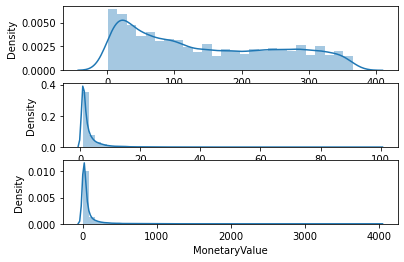

In [ ]:
# Visualize the variables (Recency, Frequency & MonetaryValue) to check the Skewness
plt.subplot(3,1,1); sns.distplot(datamart['Recency'])
plt.subplot(3,1,2); sns.distplot(datamart['Frequency'])
plt.subplot(3,1,3); sns.distplot(datamart['MonetaryValue'])

#### Unskew the data for K-means clustering

In [ ]:
# unskew by getting the logarithm of the values
datamart_log = np.log(datamart)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

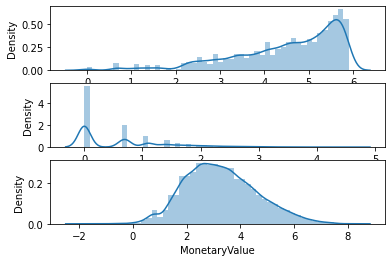

In [ ]:
# Visualize again to check its skewness
plt.subplot(3,1,1); sns.distplot(datamart_log['Recency'])
plt.subplot(3,1,2); sns.distplot(datamart_log['Frequency'])
plt.subplot(3,1,3); sns.distplot(datamart_log['MonetaryValue'])
plt.show()

# MonetaryValue after log is less skewed than before

#### Normalize the data for K-means clustering

In [ ]:
# normalize by applying sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(datamart_log)

StandardScaler()

In [ ]:
# store the normalized data back to log data for clustering
datamart_normalized = scaler.transform(datamart_log)

In [ ]:
#create dataframe with datamart_normalized
datamart_normalized = pd.DataFrame(data=datamart_normalized,
                                    index=datamart.index,
                                    columns=datamart.columns)

datamart_normalized.head()

,Recency,Frequency,MonetaryValue
Customer_ID,,,
1,1.119616,-0.800890,-0.368568
2,0.648626,0.071746,-0.115912
3,1.095115,-0.800890,-0.670309
4,-0.409904,0.071746,0.170634
5,0.246862,1.225308,0.820891


#### Running K-means
Deciding how many clusters by using Elbow method.

SSE = sum of squared errors.

After running Kmeans with k clusters, we calcuate its SSE for each k clusters.

By finding the elbow point, where it changed the angle the most, it can be used as a reference to determine the numbers of clusters for K-means.


In [ ]:
from sklearn.cluster import KMeans

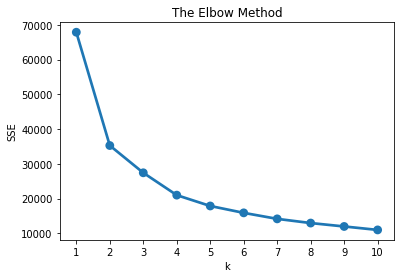

In [ ]:
# decide how many groups (K) with Elbow criterion method

#fit Kmeans and calculate SSE for each K
sse = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_


# plot sse
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

# 2 is the elbow point, thus we can try 2 or 3 clusters for K-means.

#### Analyze average RFM values of each clustering solution (k=2  & k =3)

In [ ]:
# Run K-means clustering when K=2

kmeans2 = KMeans(n_clusters=2, random_state=1)
kmeans2.fit(datamart_normalized)
cluster_labels_k2 = kmeans2.labels_

#Create a dataframe and assign the label back
datamart_rfm_k2 = datamart.assign(Cluster = cluster_labels_k2)
datamart_rfm_k2

,Recency,Frequency,MonetaryValue,Cluster
Customer_ID,,,,
1,345,1,16.29,1
2,196,2,22.77,1
3,335,1,10.92,1
4,55,2,33.29,1
5,121,5,78.82,0
...,...,...,...,...
22621,81,1,9.69,1
22622,16,1,6.07,1
22623,11,1,128.01,0


In [ ]:
#Summary (Look at Recency, Frequecny, MonetaryValue at cluster level)

datamart_rfm_k2.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(0).sort_values(('Recency','mean'),ascending=True)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0          61.0       6.0         171.0   7230
1         185.0       1.0          22.0  15395

In [ ]:
# same process for k=3

# Run K-means clustering when K=3

kmeans3 = KMeans(n_clusters=3, random_state=1)
kmeans3.fit(datamart_normalized)
cluster_labels_k3 = kmeans3.labels_

#Create a dataframe and assign the label back
datamart_rfm_k3 = datamart.assign(Cluster = cluster_labels_k3)
datamart_rfm_k3

,Recency,Frequency,MonetaryValue,Cluster
Customer_ID,,,,
1,345,1,16.29,0
2,196,2,22.77,2
3,335,1,10.92,0
4,55,2,33.29,2
5,121,5,78.82,2
...,...,...,...,...
22621,81,1,9.69,0
22622,16,1,6.07,0
22623,11,1,128.01,2


In [ ]:
#Summary (Look at Recency, Frequecny, MonetaryValue at cluster level)

datamart_rfm_k3.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(0).sort_values(('Recency','mean'),ascending=True)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
1          30.0       9.0         255.0   3651
2         124.0       3.0          64.0   7999
0         200.0       1.0          13.0  10975

#### View the result with snake plot

In [ ]:
# Using K=3 as example

# melt the data so RFM values and metric names are stored in 1 column each
datamart_k3_melt = pd.melt(datamart_rfm_k3.reset_index(),
                          id_vars=['Customer_ID','Cluster'],
                          value_vars=['Recency','Frequency','MonetaryValue'],
                          var_name='Attribute',
                          value_name='Value')
datamart_k3_melt.head()

,Customer_ID,Cluster,Attribute,Value
0,1,0,Recency,345.0
1,2,2,Recency,196.0
2,3,0,Recency,335.0
3,4,2,Recency,55.0
4,5,2,Recency,121.0


<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

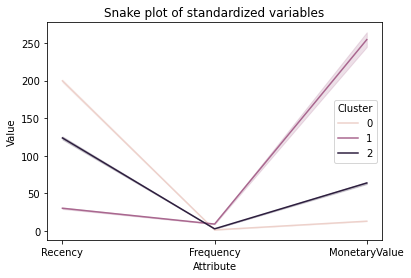

In [ ]:
#visualize a snake plot
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=datamart_k3_melt)

#### Find the relative importance of segment attributes

In [ ]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart.mean()
relative_imp= cluster_avg / population_avg -1  # compare with population avg

relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.37,-0.62,-0.82
1,-0.79,2.10,2.65
2,-0.15,-0.11,-0.09


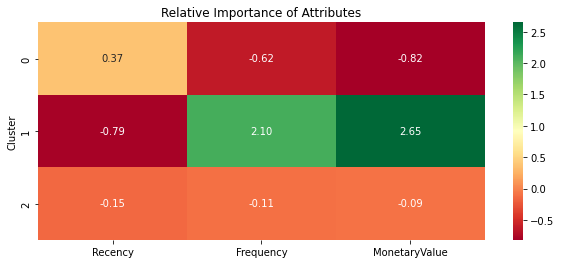

In [ ]:
# heatmap
plt.figure(figsize=(10,4))
plt.title('Relative Importance of Attributes')
sns.heatmap(data=relative_imp, annot= True, fmt='.2f', cmap='RdYlGn')
plt.show()

<a id="section-five"></a>
### Reflections & Extra Resources

- Elbow method is a good indicator for choosing the number of clusters, but it doesn't always work. Other alternatives includes:

    - [Silhouette coefficient](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
    
    - [Gap Statistics](https://web.stanford.edu/~hastie/Papers/gap.pdf)



- Limitation for K-means:

    - For high-dimensional data. You need [extra steps](https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240) in order to apply K-means clustering
    - Skewness & Normalize data [Interesting article](http://varianceexplained.org/r/kmeans-free-lunch/) challenging the assumption for K-means
    
    
- Alternatives for K-means: [Important Clustering Algorithms](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)